In [4]:
import json
import re
from collections import Counter

from itertools import groupby
from io import StringIO
import sys
import argparse
import os
import uuid
import subprocess
import networkx as nx

In [5]:
p_graph = nx.DiGraph()
p_graph.add_node("aha")
"aha" in p_graph.node

True

In [41]:
class FileHelper:
    def __init__(self):
        pass

    @staticmethod
    def is_tool(name):
        from distutils.spawn import find_executable
        return find_executable(name) is not None


class YesWorkflowNode:
    def __init__(self, name, desc=''):
        self.name = name
        self.desc = desc
        self.params = []
        self.in_node_names = []
        self.out_node_names = []

        self.raw_operator = None


def merge_basename(operator):
    # two kinds of expressions :
    # 1. the column name has space: "grel:cells[\"Sponsor 2\"].value + cells[\"Sponsor 7\"].value"  : [A-Z]\w+ \d
    # 2. the column name does not have space: "grel:cells.name.value + cells.event.value" :   \.\w+\.
    #  normal one: "grel:value"
    exp = operator['expression']
    res = operator['baseColumnName']
    if exp == 'grel:value':
        #      missing information here: if no merge other columns, we still do not know if the new column is set
        # --------dependency as basecolumnName
        result = res
        print('value: {}'.format(result))
        return result
    result = re.findall('\.\w+\.', exp)
    if result:
        newm = []
        for col in result:
            newm.append(col[1:len(col) - 1])
        result = newm
        return result
    else:
        result = re.findall('[A-Z]\w+ \d', exp)
        newm = []
        for col in result:
            newm.append(col)
        result = newm
        return result


def may_be_split_by(new_column_name, base_column_name):
    new_column_name = new_column_name.replace(" ", "_")
    base_column_name = base_column_name.replace(" ", "_")
    if len(new_column_name) <= len(base_column_name):
        return False

    base_part = new_column_name[:len(base_column_name)]
    addition_part = new_column_name[len(base_column_name):]
    print(addition_part)
    if base_part != base_column_name:
        return False
    if not re.fullmatch(r'_\d+', addition_part):
        return False

    return True


def translate_operator_json_to_yes_workflow(json_data):
    yes_workflow_data = []
    
    #variable for storing process graph
    process_graph = {}
    column_all = []

    nodes_num_about_column = Counter()

    def get_column_current_node(column_name):
        column_name = column_name.replace(" ", "_")
        if column_name not in nodes_num_about_column:  # guess split
            split_by = None
            for prev_node in reversed(yes_workflow_data):  # newest split
                if prev_node.raw_operator['op'] == 'core/column-split':
                    if may_be_split_by(
                            column_name,
                            prev_node.raw_operator['columnName'],
                    ):
                        split_by = prev_node
                        break
            if split_by is not None:  # possible split found
                node_id = nodes_num_about_column[column_name] = 1
                node_name = column_name + '_' + str(node_id)
                split_by.out_node_names.append(node_name)
                return node_name
            else:
                return create_new_node_of_column(column_name)
        else:
            node_id = nodes_num_about_column[column_name]
            return column_name + '_' + str(node_id)

    def create_new_node_of_column(column_name):
        column_name = column_name.replace(" ", "_")
        nodes_num_about_column[column_name] += 1
        return get_column_current_node(column_name)

    for operator in json_data:
        node = YesWorkflowNode(
            name=operator['op'],
            # if no description, 'no description'
            desc=operator.get('description', 'no description').replace('"','\\"'),
        )
        node.raw_operator = operator

        # initialize column_name with empty string
        column_name = ""
        process_name = ""
        input_columns = []
        output_columns = []
        
        if operator['op'] == 'core/column-addition':  # merge operation
            #     basecol=(self.params['baseColumnName']).replace(" ", "_")
            # colInsert=self.params['columnInsertIndex']
            # newcol=(self.params['newColumnName']).replace(" ", "_")
            node.params += [
                "baseColumnName:{}".format(operator['baseColumnName'].replace(" ", "_")),
                "InsertPosition:{}".format(operator['columnInsertIndex']),
                "newColumnName:{}".format(operator['newColumnName']),
                "GRELexpression:{}".format(operator['expression'])
            ]
            basename = merge_basename(operator)
            # trap for basename
            if len(basename) != 2:
                continue
            if type(basename) is list:
                baseColumnName0 = basename[0]
                baseColumnName1 = basename[1]
                node.in_node_names += [
                    get_column_current_node(baseColumnName0.replace(" ", "_")),
                    get_column_current_node(baseColumnName1.replace(" ", "_")),
                ]
            else:
                node.in_node_names += [
                    get_column_current_node(basename.replace(" ", "_")),
                ]
            node.out_node_names += [
                create_new_node_of_column(operator['newColumnName'].replace(" ", "_")),
            ]
            
            # assign column_name
            column_name = operator['baseColumnName']
            output_columns.append(operator["newColumnName"])            
        elif operator['op'] == 'core/column-split':  # split operation
            node.params += [
                "columnName:{}".format(operator['columnName'].replace(" ", "_")),
                "removeOriginalColumn:{}".format(operator['removeOriginalColumn']),
                "separator:{}".format(operator['separator']),
            ]
            node.in_node_names += [
                get_column_current_node(operator['columnName']),
            ]
            # assign column_name
            column_name = operator['columnName']            
        elif operator['op'] == 'core/column-rename':  # split operation
            node.params += [
                "oldColumnName:{}".format(operator['oldColumnName']),
                "newColumnName:{}".format(operator['newColumnName']),
            ]
            node.in_node_names += [
                get_column_current_node(operator['oldColumnName']),
            ]
            node.out_node_names += [
                create_new_node_of_column(operator['newColumnName']),
            ]
            # assign column_name
            column_name = operator['oldColumnName']
            output_columns.append(operator["newColumnName"])
        elif operator['op'] == 'core/column-removal':
            continue
        else:  # normal unary operation
            #print("op: ",operator.items())
            node.params += [
                "columnName:{}".format(operator['columnName']),
                "expression:{}".format(operator['expression']),
            ]
            node.in_node_names += [
                get_column_current_node(operator['columnName']),
            ]
            node.out_node_names += [
                create_new_node_of_column(operator['columnName']),
            ]
            # assign column_name
            column_name = operator['columnName']            

        # rewrite the params, replace space with _ to avoid unexpected cut values
        for i,x in enumerate(node.params):
            node.params[i] = x.replace(" ","_")

        # check column_name and retrace the graph
        if column_name!="":
            # check if it's already recorded previouly
            if column_name not in column_all:
                column_all.append(column_name)
                # check if it's result from the split column operation                
                temp_col_arr = column_name.split(" ")
                #print(temp_col_arr)
                if len(temp_col_arr)>1:
                    # check if the last index is a numeric
                    #is_num = False
                    try:
                        # assert convert to int
                        assert int(temp_col_arr[-1]) > 0
                        #is_num=True
                        source_column = " ".join(temp_col_arr[0:-1])
                        #print(source_column)
                        #print(column_all)
                        if source_column in column_all:
                            # trace process in the source column
                            # to get split operation
                            #print("in all")
                            for p_temp in process_graph[source_column]:
                                #print(p_temp)
                                if p_temp["op"]=="core/column-split":                                                 
                                    #input_columns.append("{}-p{}".format(source_column,p_temp["index"]))
                                    input_columns.append("{}-p{}".format(source_column,p_temp["index"]))
                            #print(input_columns)
                    except:
                        pass
                        
                        
            # check if the colunn_name in the node
            if column_name not in process_graph.keys():
                # add new _node
                process_graph[column_name] = []
            process_graph[column_name].append({"index": len(process_graph[column_name])+1,"op": operator["op"], "all_op": operator, "input": input_columns,"output": output_columns})                        
                                                                
        yes_workflow_data.append(node)        
    
    # recreate graph
    p_graph = nx.DiGraph()
    temp_output_edges = []
    for col_key,col_item in process_graph.items():
        p_graph.add_node(col_key,attr={"op": "input_column","index": 0})
        source_node = col_key
        for i, process in enumerate(col_item):
            process_node = "{}-p{}".format(col_key,i+1)
            p_graph.add_node(process_node,attr=process)
            p_graph.add_edge(source_node,process_node)
            for output in process["output"]:
                temp_output_edges.append((process_node,output))
            for t_input in process["input"]:
                #temp_input_edges.append(t_input,process_node)
                #print(t_input)
                temp_output_edges.append((t_input,process_node))
            source_node = process_node

    # recreate output connection
    for output_edge in temp_output_edges:
        #print(output_edge)
        p_graph.add_edge(output_edge[0],output_edge[1])
                                        
    return yes_workflow_data,p_graph


def getparams_from_ywdata(yes_workflow_data):
    paramsinputlist = []
    for node in yes_workflow_data:
        for params_name in node.params:
            paramsinputlist.append(params_name)
    return list(set(paramsinputlist))


def getinput_from_ywdata(yes_workflow_data):
    inputlist = []
    for node in yes_workflow_data:
        for in_node_name in node.in_node_names:
            inputlist.append(in_node_name)
    return list(set(inputlist))


def getouput_from_ywdata(yes_workflow_data):
    outputlist = []
    for node in yes_workflow_data:
        for out_node_name in node.out_node_names:
            outputlist.append(out_node_name)
    return list(set(outputlist))


def write_yes_workflow_data_to_file(yes_workflow_data, file):
    counter = 0
    for node in yes_workflow_data:
        print('#@begin {}{}'.format(node.name, counter), '#@desc', node.desc, file=file)
        for param in node.params:
            print('#@param', param, file=file)
        for in_node_name in node.in_node_names:
            print('#@in', in_node_name, file=file)
        for out_node_name in node.out_node_names:
            print('#@out', out_node_name, file=file)
        print('#@end {}{}'.format(node.name, counter), file=file)
        counter += 1

In [42]:
json_dict = None
with open("OR-history-1.json", "r") as file:
    json_dict = json.load(file)

In [43]:
_, p_graph = translate_operator_json_to_yes_workflow(json_dict)

In [44]:
p_graph.edges

OutEdgeView([('occasion-p266', 'occasion-p267'), ('occasion-p183', 'occasion-p184'), ('event-p14', 'event-p15'), ('event-p145', 'event-p146'), ('occasion-p272', 'occasion-p273'), ('event-p146', 'event-p147'), ('occasion-p242', 'occasion-p243'), ('occasion-p97', 'occasion-p98'), ('event-p198', 'event-p199'), ('occasion-p126', 'occasion-p127'), ('occasion-p140', 'occasion-p141'), ('event-p59', 'event-p60'), ('occasion-p50', 'occasion-p51'), ('occasion-p26', 'occasion-p27'), ('event-p170', 'event-p171'), ('event-p23', 'event-p24'), ('occasion-p170', 'occasion-p171'), ('occasion-p148', 'occasion-p149'), ('occasion-p28', 'occasion-p29'), ('occasion-p199', 'occasion-p200'), ('occasion-p184', 'occasion-p185'), ('occasion-p144', 'occasion-p145'), ('occasion-p89', 'occasion-p90'), ('event-p7', 'event-p8'), ('event-p202', 'event-p203'), ('event-p148', 'event-p149'), ('occasion-p54', 'occasion-p55'), ('occasion-p80', 'occasion-p81'), ('occasion-p62', 'occasion-p63'), ('occasion-p202', 'occasion-p

In [56]:
import pandas as pd
index_arr = []
node_arr = []
op_arr = []
for x in p_graph.edges:
    #print(x[0],x[1])
    index_arr.append((p_graph.node[x[0]]["attr"]["index"],p_graph.node[x[1]]["attr"]["index"]))
    node_arr.append((x[0],x[1]))
    op_arr.append((p_graph.node[x[0]]["attr"]["op"],p_graph.node[x[1]]["attr"]["op"]))

In [54]:
for x in test_arr:
    print(x)
    break

('occasion-p266', 'core/mass-edit', 266, 'occasion-p267', 'core/mass-edit', 267)


In [46]:
test_df = pd.DataFrame(test_arr,columns=["n1","op1","index1","n2","op2","index2"])

In [57]:
test_df = pd.DataFrame(op_arr)

In [63]:
#test_df.groupby(["op1","op2"]).count()
test_df["count"] = 1
test_df.groupby([0,1],as_index=False).count()

,0,1,count
0,core/mass-edit,core/mass-edit,463
1,core/mass-edit,core/text-transform,9
2,core/text-transform,core/mass-edit,10
3,core/text-transform,core/text-transform,23
4,input_column,core/text-transform,5


In [85]:
p_graph.edges("occasion-p2")
p_graph.node["occasion-p2"]

{'attr': {'all_op': {'columnName': 'occasion',
   'description': 'Mass edit cells in column occasion',
   'edits': [{'from': ['ANNIVERSARY;',
      'ANNIVERSARY (?);',
      'ANNIVERSARY(?);',
      'ANNIVERSARY',
      'ANNIVERSARY.',
      'ANNIVERSARY?'],
     'fromBlank': False,
     'fromError': False,
     'to': 'ANNIVERSARY'},
    {'from': ['OTHER (ANNIVERSARY);',
      'OTHER (ANNIVERSARY)',
      'OTHER (ANNIVERSARY?)',
      'OTHER - ANNIVERSARY',
      'OTHER {ANNIVERSARY};'],
     'fromBlank': False,
     'fromError': False,
     'to': 'ANNIVERSARY'},
    {'from': ['[ANNIV?];', '(ANNIV);', '(ANNIV?);', '[?ANNIV?];', '[ANNIV?]'],
     'fromBlank': False,
     'fromError': False,
     'to': 'ANNIVERSARY'},
    {'from': ['OTHER (ANNUAL EVENT)',
      'OTHER (ANNUAL EVENT);',
      'OTHER {ANNUAL EVENT};',
      'OTHER, ANNUAL EVENT'],
     'fromBlank': False,
     'fromError': False,
     'to': 'ANNUAL'},
    {'from': ['DAILY;', 'DAILY', '[DAILY]', 'DAILY?;'],
     'fromBlank'

In [91]:
index_arr2 = []
node_arr2 = []
op_arr2 = []
for i,x in enumerate(node_arr):
    #print(x[0],x[1])
    #print(x)
    #all_trace = []
    # trace the direct leaves from the end
    for y in p_graph.edges(x[len(x)-1]):   
        #print(y[1])
        a_node = list(x) 
        a_op = list(op_arr[i])
        a_node.append(y[1])
        a_attr = p_graph.node[y[1]]
        #print(a_attr)
        a_op.append(a_attr["attr"]["op"])
        node_arr2.append(a_node)
        op_arr2.append(a_op)
    #print(node_arr2)
    #print(op_arr2)
    #index_arr.append((p_graph.node[x[0]]["attr"]["index"],p_graph.node[x[1]]["attr"]["index"]))
    #node_arr.append((x[0],x[1]))
    #op_arr.append((p_graph.node[x[0]]["attr"]["op"],p_graph.node[x[1]]["attr"]["op"]))
    #break

In [92]:
#test_df.groupby(["op1","op2"]).count()
test_df = pd.DataFrame(op_arr2)
test_df["count"] = 1
test_df.groupby([0,1,2],as_index=False).count()

,0,1,2,count
0,core/mass-edit,core/mass-edit,core/mass-edit,457
1,core/mass-edit,core/mass-edit,core/text-transform,5
2,core/mass-edit,core/text-transform,core/mass-edit,2
3,core/mass-edit,core/text-transform,core/text-transform,7
4,core/text-transform,core/mass-edit,core/mass-edit,6
5,core/text-transform,core/mass-edit,core/text-transform,4
6,core/text-transform,core/text-transform,core/mass-edit,6
7,core/text-transform,core/text-transform,core/text-transform,15
8,input_column,core/text-transform,core/mass-edit,2
9,input_column,core/text-transform,core/text-transform,1


In [93]:
index_arr3 = []
node_arr3 = []
op_arr3 = []
for i,x in enumerate(node_arr2):
    #print(x[0],x[1])
    #print(x)
    #all_trace = []
    # trace the direct leaves from the end
    for y in p_graph.edges(x[len(x)-1]):
        #print(y[1])
        a_node = list(x) 
        a_op = list(op_arr2[i])
        a_node.append(y[1])
        a_attr = p_graph.node[y[1]]
        #print(a_attr)
        a_op.append(a_attr["attr"]["op"])
        node_arr3.append(a_node)
        op_arr3.append(a_op)
    #print(node_arr2)
    #print(op_arr2)
    #index_arr.append((p_graph.node[x[0]]["attr"]["index"],p_graph.node[x[1]]["attr"]["index"]))
    #node_arr.append((x[0],x[1]))
    #op_arr.append((p_graph.node[x[0]]["attr"]["op"],p_graph.node[x[1]]["attr"]["op"]))
    #break

In [95]:
#test_df.groupby(["op1","op2"]).count()
test_df = pd.DataFrame(op_arr3)
test_df["count"] = 1
test_df.groupby([0,1,2,3],as_index=False).count()

,0,1,2,3,count
0,core/mass-edit,core/mass-edit,core/mass-edit,core/mass-edit,453
1,core/mass-edit,core/mass-edit,core/mass-edit,core/text-transform,3
2,core/mass-edit,core/mass-edit,core/text-transform,core/mass-edit,1
3,core/mass-edit,core/mass-edit,core/text-transform,core/text-transform,4
4,core/mass-edit,core/text-transform,core/mass-edit,core/mass-edit,2
5,core/mass-edit,core/text-transform,core/text-transform,core/mass-edit,1
6,core/mass-edit,core/text-transform,core/text-transform,core/text-transform,6
7,core/text-transform,core/mass-edit,core/mass-edit,core/mass-edit,4
8,core/text-transform,core/mass-edit,core/mass-edit,core/text-transform,2
9,core/text-transform,core/mass-edit,core/text-transform,core/mass-edit,1


In [96]:
index_arr4 = []
node_arr4 = []
op_arr4 = []
for i,x in enumerate(node_arr3):
    #print(x[0],x[1])
    #print(x)
    #all_trace = []
    # trace the direct leaves from the end
    for y in p_graph.edges(x[len(x)-1]):
        #print(y[1])
        a_node = list(x) 
        a_op = list(op_arr3[i])
        a_node.append(y[1])
        a_attr = p_graph.node[y[1]]
        #print(a_attr)
        a_op.append(a_attr["attr"]["op"])
        node_arr4.append(a_node)
        op_arr4.append(a_op)
    #print(node_arr2)
    #print(op_arr2)
    #index_arr.append((p_graph.node[x[0]]["attr"]["index"],p_graph.node[x[1]]["attr"]["index"]))
    #node_arr.append((x[0],x[1]))
    #op_arr.append((p_graph.node[x[0]]["attr"]["op"],p_graph.node[x[1]]["attr"]["op"]))
    #break

In [97]:
#test_df.groupby(["op1","op2"]).count()
test_df = pd.DataFrame(op_arr4)
test_df["count"] = 1
test_df.groupby([0,1,2,3,4],as_index=False).count()

,0,1,2,3,4,count
0,core/mass-edit,core/mass-edit,core/mass-edit,core/mass-edit,core/mass-edit,449
1,core/mass-edit,core/mass-edit,core/mass-edit,core/mass-edit,core/text-transform,3
2,core/mass-edit,core/mass-edit,core/mass-edit,core/text-transform,core/text-transform,3
3,core/mass-edit,core/mass-edit,core/text-transform,core/mass-edit,core/mass-edit,1
4,core/mass-edit,core/mass-edit,core/text-transform,core/text-transform,core/mass-edit,1
5,core/mass-edit,core/mass-edit,core/text-transform,core/text-transform,core/text-transform,3
6,core/mass-edit,core/text-transform,core/mass-edit,core/mass-edit,core/mass-edit,1
7,core/mass-edit,core/text-transform,core/mass-edit,core/mass-edit,core/text-transform,1
8,core/mass-edit,core/text-transform,core/text-transform,core/mass-edit,core/mass-edit,1
9,core/mass-edit,core/text-transform,core/text-transform,core/text-transform,core/mass-edit,1


In [50]:
test_df.sort_values("index1")

,n1,op1,index1,n2,op2,index2
408,location,input_column,0,location-p1,core/text-transform,1
418,notes,input_column,0,notes-p1,core/text-transform,1
365,meal,input_column,0,meal-p1,core/text-transform,1
218,occasion,input_column,0,occasion-p1,core/text-transform,1
195,event,input_column,0,event-p1,core/text-transform,1
444,occasion-p1,core/text-transform,1,occasion-p2,core/mass-edit,2
403,event-p1,core/text-transform,1,event-p2,core/mass-edit,2
91,meal-p1,core/text-transform,1,meal-p2,core/text-transform,2
492,occasion-p2,core/mass-edit,2,occasion-p3,core/mass-edit,3
281,event-p2,core/mass-edit,2,event-p3,core/mass-edit,3


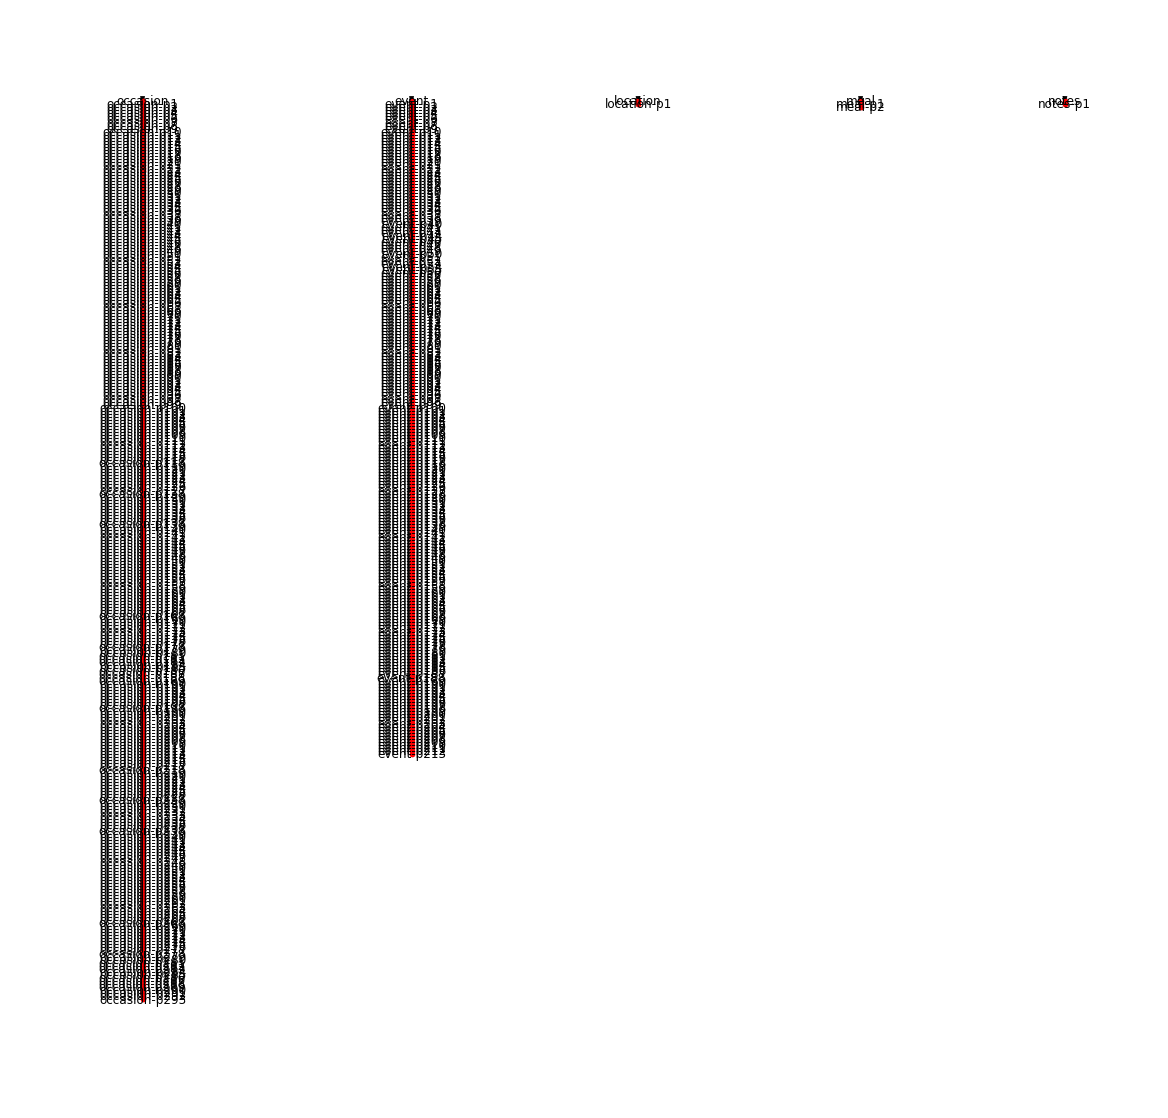

In [20]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

pos=graphviz_layout(p_graph, prog='dot')
from matplotlib import pyplot  as plt
%matplotlib inline

plt.figure(figsize=(20, 20))  # image is 8 x 8 inches
plt.axis('off')
#nx.draw_networkx_nodes(g_tree, pos, node_size=40, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(p_graph, pos, node_size=20, cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(p_graph, pos, alpha=0.9)
nx.draw(p_graph, pos, node_size=20, with_labels = True)
plt.show(p_graph)

In [3]:
class OR2YW:
    def __init__(self):
        """
        Init function for this class, put any initialization attributes that you need here

        """
        pass

    @staticmethod
    def generate_yw_serial(operations, title="Linear_OR", description="Linear OpenRefine Workflow"):
        if title == None:
            title = "Linear_OR"
        if description == None:
            description = "Linear OpenRefine Workflow"
        inputdatalist = []
        data = operations
        outputfinal = 'table' + str(len(data))
        for dicts in data:
            # print('#@begin '+dicts['op']+'#@desc '+dicts['description']+'\n')
            if dicts['op'] == 'core/column-rename':
                # print('#@in '+dicts['oldColumnName']+'\n')
                # print('#@in '+dicts['newColumnName']+'\n')
                oldColumnName = 'oldColumnName:' + dicts['oldColumnName']
                newColumnName = 'newColumnName:' + dicts['newColumnName']
                inputdatalist.append(oldColumnName)
                inputdatalist.append(newColumnName)
            elif dicts['op'] == 'core/mass-edit':
                colname = 'col-name:' + dicts['columnName']
                inputdatalist.append(colname)
            elif dicts['op'] == 'core/text-transform':
                colname = 'col-name:' + dicts['columnName']
                expression = 'expression:' + dicts['expression']
                inputdatalist.append(colname)
                inputdatalist.append(expression)
            elif dicts['op'] == 'core/column-split':
                colname = 'col-name:' + dicts['columnName']
                separator = 'separator:' + '"%s"' % (dicts['separator'])
                remove = 'removeOriginalColumn:%s' % dicts['removeOriginalColumn']
                inputdatalist.append(colname)
                inputdatalist.append(separator)
                inputdatalist.append(remove)

            elif dicts['op'] == 'core/column-addition':
                colname = 'col-name:' + dicts['baseColumnName']
                newColumnName = 'newColumnName:{}'.format(dicts['newColumnName'])
                inputdatalist.append(colname)
                inputdatalist.append(newColumnName)

        deinputdatalist = set(inputdatalist)

        # for sublist in list(deinputdatalist):
        #     print('#@in '+sublist)

        # for the subset of the procedure

        # parse and print it out
        # f = open('../yw/Original_LinearParseYW.txt', 'w')
        f = StringIO()
        f.write('#@begin {0} #@desc {1}\n'.format(title, description))
        for sublist in list(deinputdatalist):
            f.write('#@param ' + sublist + '\n')
        f.write('#@in table0\n')
        f.write('#@out ' + outputfinal + '\n')
        rename_c = 0
        massedit_c = 0
        texttrans_c = 0
        colsplit_c = 0
        coladdit_c = 0
        table_c = 0
        for dicts in data:
            dicts['description'] = dicts['description'].replace('"', '\\"')
            if dicts['op'] == 'core/column-rename':
                f.write('#@begin core/column-rename%d' % rename_c + '#@desc ' + dicts['description'] + '\n')
                f.write('#@param oldColumnName:' + dicts['oldColumnName'] + '\n')
                f.write('#@param newColumnName:' + dicts['newColumnName'] + '\n')
                f.write('#@in table%d\n' % table_c)
                table_c += 1
                f.write('#@out table%d\n' % table_c)
                f.write('#@end core/column-rename%d\n' % rename_c)

                rename_c += 1

            elif dicts['op'] == 'core/mass-edit':
                f.write('#@begin core/mass-edit%d' % massedit_c + '#@desc ' + dicts['description'] + '\n')
                f.write('#@param col-name:' + dicts['columnName'] + '\n')
                f.write('#@in table%d\n' % table_c)
                table_c += 1
                f.write('#@out table%d\n' % table_c)
                f.write('#@end core/mass-edit%d\n' % massedit_c)
                massedit_c += 1
            elif dicts['op'] == 'core/text-transform':
                f.write('#@begin core/text-transform%d' % texttrans_c + '#@desc ' + dicts['description'] + '\n')
                f.write('#@param col-name:' + dicts['columnName'] + '\n')
                f.write('#@param expression:' + dicts['expression'] + '\n')
                f.write('#@in table%d\n' % table_c)
                table_c += 1
                f.write('#@out table%d\n' % table_c)
                f.write('#@end core/text-transform%d\n' % texttrans_c)
                texttrans_c += 1
            elif dicts['op'] == 'core/column-split':
                f.write('#@begin core/column-split%d' % colsplit_c + '#@desc ' + dicts['description'] + '\n')
                f.write('#@param col-name:' + dicts['columnName'] + '\n')
                f.write('#@param separator:' + '"%s"' % (dicts['separator']) + '\n')
                f.write('#@param removeOriginalColumn:%s\n' % dicts['removeOriginalColumn'])
                f.write('#@in table%d\n' % table_c)
                table_c += 1
                f.write('#@out table%d\n' % table_c)
                f.write('#@end core/column-split%d\n' % colsplit_c)
                colsplit_c += 1
                # {
                #     "op": "core/column-addition",
                #     "description": "Create column Sponsor1 at index 3 based on column Sponsor using expression grel:value",
                #     "engineConfig": {
                #         "mode": "row-based",
                #         "facets": []
                #     },
                #     "newColumnName": "Sponsor1",
                #     "columnInsertIndex": 3,
                #     "baseColumnName": "Sponsor",
                #     "expression": "grel:value",
                #     "onError": "keep-original"
                # },
            elif dicts['op'] == 'core/column-addition':
                f.write('#@begin core/column-addition%d' % coladdit_c + '#@desc ' + dicts['description'] + '\n')
                f.write('#@param col-name:' + dicts['baseColumnName'] + '\n')
                f.write('#@param newColumnName:' + '"%s"' % (dicts['newColumnName']) + '\n')
                f.write('#@in table%d\n' % table_c)
                table_c += 1
                f.write('#@out table%d\n' % table_c)
                f.write('#@end core/column-addition%d\n' % coladdit_c)
                coladdit_c += 1

        f.write('#@end {}\n'.format(title))
        output_string = f.getvalue()
        f.close()

        # clear space chars in param, in, and out notation
        output_list = output_string.split("\n")
        for i,x in enumerate(output_list):
            if x.startswith("#@param"):
                print(x)
                output_list[i] = "#@param " + x[8:].replace(" ","_")
            elif x.startswith("#@in"):
                output_list[i] = "#@in " + x[5:].replace(" ", "_")
            elif x.startswith("#@out"):
                output_list[i] = "#@out " + x[6:].replace(" ", "_")

        output_string = "\n".join(output_list)

        # output_string = output_string.replace('"','\\"')
        return output_string

    @staticmethod
    def generate_yw_parallel(operations, title="Parallel_OR", description="Parallel OpenRefine Workflow"):
        """
        given a list of operations in dictionary format, return yes workflow script in text
        id: list of operations dictionary / json format
        return yw_script (text / string)
        :return:
        """
        if title == None:
            title = "Parallel_OR"
        if description == None:
            description = "Parallel OpenRefine Workflow"
        yes_workflow_data = translate_operator_json_to_yes_workflow(operations)
        f = StringIO()
        # with open('yes_workflow_script.txt', 'wt', encoding='utf-8') as f:
        print('#@begin {}'.format(title), '#@desc {}'.format(description), file=f)
        inputlist = getinput_from_ywdata(yes_workflow_data)
        paramslist = getparams_from_ywdata(yes_workflow_data)
        for params in paramslist:
            print('#@param {}'.format(params.replace(" ","_")), file=f)
        for input in inputlist:
            print('#@in {}'.format(input.replace(" ","_")), file=f)
        print('#@out {}'.format('CleanData'), file=f)

        # Data Cleaning steps
        write_yes_workflow_data_to_file(yes_workflow_data, f)

        # merge??
        print('#@begin CombineDataCleaningChanges', file=f)
        outputlist = getouput_from_ywdata(yes_workflow_data)
        for output in outputlist:
            print('#@in {}'.format(output.replace(" ","_")), file=f)
        print('#@out {}'.format('CleanData'), file=f)
        print('#@end {}'.format('CombineDataCleaningChanges'), file=f)
        print('#@end {}'.format(title), file=f)
        output_string = f.getvalue()
        f.close()
        return output_string

    @staticmethod
    def generate_vg(yw_string, gv_file, java_path=None):
        temp_folder = ""
        tempid = str(uuid.uuid4())
        text_name = "tmp-" + tempid + ".yw"
        # gv_name = "tmp-" + tempid + ".gv"
        with open(temp_folder + text_name, "w") as f:
            f.write(yw_string)
        # look for java
        if java_path != None:
            if not os.path.isfile(java_path):
                raise BaseException(
                    "Java Binary: {} not found".format(java_path))
        elif FileHelper.is_tool("java"):
            java_path = "java"
        # print(java_path)
        if java_path == None:
            # print("You must have java to run this operation")
            raise BaseException(
                "You must have java to run this operation, or use --java={java_path} to specify java binary")
        print("java found: ", java_path)
        from or2ywtool import OR2YWCore
        path = os.path.dirname(OR2YWCore.__file__)
        # print(path)

        import shutil
        # copy yw.properties to run directory
        shutil.copyfile(path + "/yw.properties", "./yw.properties")

        cmd = "cat {} | {} -jar {} graph -c extract.comment='#' > {}".format(temp_folder + text_name, java_path,
                                                                             path + "/yesworkflow-0.2.2.0-SNAPSHOT-jar-with-dependencies.jar",
                                                                             gv_file)
        ps = subprocess.Popen(cmd, shell=True, stderr=subprocess.STDOUT)
        output, error_output = ps.communicate()
        ps.wait()
        os.remove(temp_folder + text_name)
        if error_output != None:
            raise BaseException("you  must have java installed\n" + error_output)
        return gv_file

    @staticmethod
    def generate_dot(yw_string, dot_file, dot_type="png", java_path=None, dot_path=None):
        temp_folder = ""
        tempid = str(uuid.uuid4())
        vg_filename = "{}.vg".format(tempid)
        vg_filename = OR2YW.generate_vg(yw_string, vg_filename, java_path=java_path)
        if dot_path != None:
            if not os.path.isfile(dot_path):
                raise BaseException(
                    "Dot binary: {} not found".format(dot_path))
        elif FileHelper.is_tool("dot"):
            dot_path = "dot"
        if dot_path == None:
            raise BaseException(
                "You must have dot (graphviz) to run this operation, or use --dot={dot_path} to specify dot binary")
        print("dot found: ", dot_path)
        cmd = "{} -T{} {} -o {}".format(dot_path, dot_type, vg_filename, dot_file)
        ps = subprocess.Popen(cmd, shell=True, stderr=subprocess.STDOUT)
        output, error_output = ps.communicate()
        ps.wait()
        os.remove(vg_filename)
        if error_output != None:
            raise BaseException("you  must have dot (graphviz) installed\n" + error_output)
        return dot_file

